### Data Shifting Experiment

### MIMIC CXR

* [Dataset](https://physionet.org/content/mimic-cxr/2.0.0/)

* [Original Paper](https://www.nature.com/articles/s41597-019-0322-0)

In [1]:
%cd ..

/home/datascience/Data Fusion


In [2]:
import os
import numpy as np
import pandas as pd

from src.classifiers import preprocess_data, process_labels, split_data
from src.classifiers import VQADataset
from torch.utils.data import DataLoader
from src.classifiers import train_early_fusion, train_late_fusion

from utils import normalize_embeddings, modify_and_normalize_embeddings, visualize_embeddings, plot_results

In [3]:
PATH = 'Embeddings_vlm/mimic/'
FILE = 'embeddings_clip.csv'
DATASET = 'mimic'

batch_size = 32

output_size = 4
multilabel = False

num_epochs = 50

In [4]:
df = pd.read_csv(os.path.join(PATH, FILE))
df.drop(columns=['image_id', 'text'], inplace=True)
df.disease_label = df.disease_label.astype(str)
df.head()

,path,race_label,sex_label,disease_label,subject_id,study_id,split,file_path,image_embedding_0,image_embedding_1,...,text_embedding_502,text_embedding_503,text_embedding_504,text_embedding_505,text_embedding_506,text_embedding_507,text_embedding_508,text_embedding_509,text_embedding_510,text_embedding_511
0,p19/p19702416/s51321189/d85c9f15-f0f84927-761f...,0,0,3,19702416,51321189,train,datasets/mimic/files/p19/p19702416/s51321189.txt,0.017584,-0.003019,...,-0.052364,-0.018894,0.101141,0.003454,-0.030474,0.013750,-0.007859,0.061135,0.050736,-0.005674
1,p13/p13339704/s51292704/0024603b-12db30e2-ab32...,2,0,3,13339704,51292704,train,datasets/mimic/files/p13/p13339704/s51292704.txt,0.025167,-0.008093,...,-0.045582,-0.014851,0.052466,-0.013415,-0.023199,0.001723,0.004433,0.036226,0.035885,-0.000904
2,p13/p13339704/s51292704/7953848d-2411f0df-859f...,2,0,3,13339704,51292704,train,datasets/mimic/files/p13/p13339704/s51292704.txt,0.027844,-0.001912,...,-0.045582,-0.014851,0.052466,-0.013415,-0.023199,0.001723,0.004433,0.036226,0.035885,-0.000904
3,p12/p12668169/s54048859/8a4aaaee-55fcf98f-a036...,0,0,3,12668169,54048859,train,datasets/mimic/files/p12/p12668169/s54048859.txt,0.041953,0.002593,...,-0.031608,-0.018585,0.020580,0.012898,0.000496,0.035545,0.023832,-0.059201,0.019583,-0.003538
4,p10/p10309415/s58144222/9886b0fe-9121c65e-c8d7...,0,0,3,10309415,58144222,train,datasets/mimic/files/p10/p10309415/s58144222.txt,0.012712,0.006450,...,-0.038537,-0.009317,0.057783,-0.010010,-0.025244,0.002658,0.010754,0.027053,0.024629,0.007983


In [5]:
# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column]
image_columns = [column for column in df.columns if 'image' in column]
label_columns = 'disease_label'

### Run Experiments

##################################################  Shift -1  ##################################################


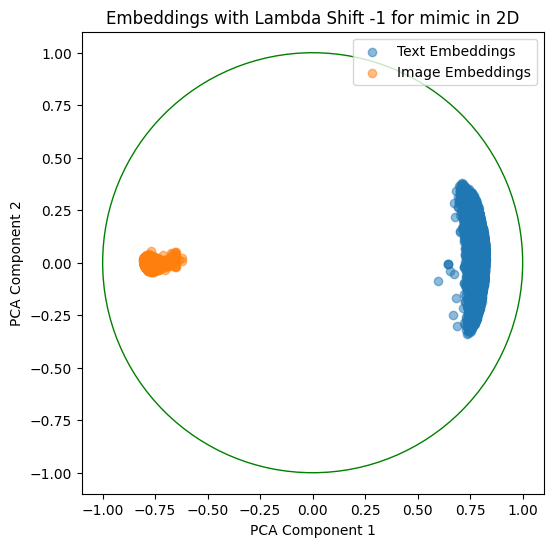

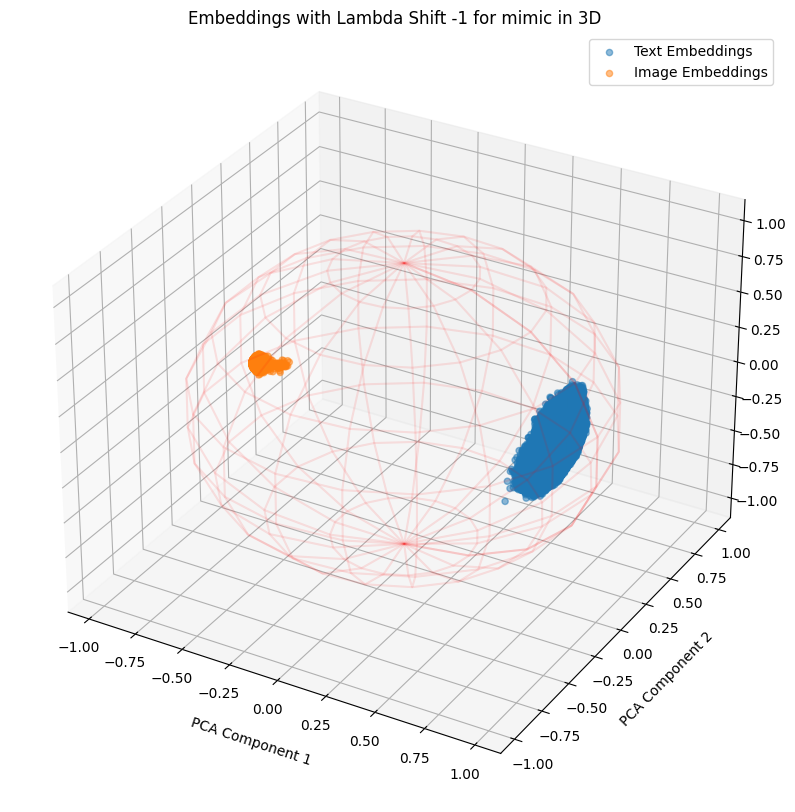

Train Shape: (107695, 1032)
Test Shape: (30360, 1032)
Training Early Fusion Model:
The number of parameters of the model are: 131972


In [ ]:
# Assuming df is your DataFrame
#lambda_shift_values = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Negative values bring embeddings closer, positive values push them apart
lambda_shift_values = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]  # Negative values bring embeddings closer, positive values push them apart

# Normalize initial embeddings
df[text_columns] = normalize_embeddings(df[text_columns].values)
df[image_columns] = normalize_embeddings(df[image_columns].values)

# Dataframe with shifted values:
df_shifted = df.copy()

results = {}

for lambda_shift in lambda_shift_values:
    
    print('#'*50, f' Shift {lambda_shift} ', '#'*50)
    
    # Extract embeddings
    text_embeddings = df[text_columns].values
    image_embeddings = df[image_columns].values
    
    # Modify and normalize embeddings
    text_embeddings_shifted, image_embeddings_shifted = modify_and_normalize_embeddings(text_embeddings, image_embeddings, lambda_shift)
    
    # Update column names based on the new dimensions
    if text_embeddings.shape[1] < text_embeddings_shifted.shape[1]:
        text_columns_updated = update_column_names(text_columns, text_embeddings_shifted.shape[1])
    else: 
        text_columns_updated = text_columns
        
    if image_embeddings.shape[1] < image_embeddings_shifted.shape[1]: 
        image_columns_updated = update_column_names(image_columns, image_embeddings_shifted.shape[1])
    else:
        image_columns_updated = image_columns
    
    # Update DataFrame with shifted embeddings
    df_shifted[text_columns_updated] = text_embeddings_shifted
    df_shifted[image_columns_updated] = image_embeddings_shifted
    
    # Visualize shifted embeddings
    visualize_embeddings(text_embeddings_shifted, image_embeddings_shifted, f'Embeddings with Lambda Shift {lambda_shift} for {DATASET}', lambda_shift, DATASET)
    
    # Split the data
    train_df, test_df = split_data(df_shifted)
    
    
    # Process and one-hot encode labels for training set
    train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
    test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)

    train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
    test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    text_input_size = len(text_columns)
    image_input_size = len(image_columns)

    ### Models:
    # Train early fusion model
    print("Training Early Fusion Model:")
    accuracy, precision, recall, f1, best = train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=num_epochs, multilabel=multilabel, report=True, V=False)
    print(f"Best Accuracy: {best['Acc']}")
    print(f"Best Macro-F1: {best['Macro-F1']}")
    print(f"Best Macro-AUC: {best['AUC']}")
    
    results[f"early_({lambda_shift})"] = best
    
    # Train late fusion model
    print("Training Late Fusion Model:")
    accuracy, precision, recall, f1, best = train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=num_epochs, multilabel=multilabel, report=True, V=False)
    print(f"Best Accuracy: {best['Acc']}")
    print(f"Best Macro-F1: {best['Macro-F1']}")
    print(f"Best Macro-AUC: {best['AUC']}")
    
    results[f"late_({lambda_shift})"] = best

In [ ]:
print('Results Early Fusion: ')
for lambda_shift in lambda_shift_values:
    print(f'Shift = {lambda_shift}')
    print(f"Best Accuracy: {results[f'early_({lambda_shift})']['Acc']}")
    print(f"Best F1: {results[f'early_({lambda_shift})']['Macro-F1']}")
    print(f"Best AUC: {results[f'early_({lambda_shift})']['AUC']}")
    
print('Results Late Fusion: ')
for lambda_shift in lambda_shift_values:
    print(f'Shift = {lambda_shift}')
    print(f"Best Accuracy: {results[f'late_({lambda_shift})']['Acc']}")
    print(f"Best F1: {results[f'late_({lambda_shift})']['Macro-F1']}")
    print(f"Best AUC: {results[f'early_({lambda_shift})']['AUC']}")

In [ ]:
plot_results(results, lambda_shift_values, DATASET)